In [76]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

In [77]:
import scraper

category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph, infos  = await scraper.scrape_wiki(category_titles)

Fetching 7363 talk pages:  12%|█▏        | 18/148 [00:07<00:38,  3.40it/s]

CancelledError: 

In [52]:
import os
import scraper
import re
import numpy as np
import networkx as nx
from tqdm.asyncio import tqdm

def parse_page(raw_content):
    # Normalize whitespace
    content = re.sub(r'[\n\t\ ]+', ' ', raw_content)

    # Retreive links to all pages
    all_links = np.unique(re.findall('\[([^/\]\[\|]+)[\]\|]', content))
    # Retreive links to User: pages
    user_links = np.unique(re.findall('\[(User:[^/\]\[\|]+)[\]\|]', content))
    # Retreive links to Talk: pages
    talk_links = np.unique(re.findall('\[((talk:|Talk:|User talk:|Wikipedia talk:)[^/\]\[\|]+)[\]\|]', content))
    article_links = [link for link in all_links if link not in user_links and link not in talk_links]
    return {"article": article_links, "user": user_links, "talk": talk_links}

def get_titles(filenames):
    return [fname[:-4] if fname[-4:] == ".txt" else fname for fname in filenames]

def parse_class(titles, dirpath):
    data = {}
    for title in titles:
        filepath = f"{dirpath}/{title}.txt"
        if os.path.isfile(filepath):
            with open(filepath, "r") as fh:
                content = fh.read()
                data[title] = parse_page(content)
        else:
            pass
    return data

def build_network_local():
    path = "./page_contents"
    talk_titles = get_titles(os.listdir(f"{path}/talks"))
    article_titles = get_titles(os.listdir(f"{path}/articles"))
    
    # Graph
    page_graph = nx.DiGraph()

    for talk_page_title in talk_titles:
        page_graph.add_node(talk_page_title, page_class="talk")
    for wiki_page_title in article_titles:
        page_graph.add_node(wiki_page_title, page_class="article")
        page_graph.add_edge(f"Talk:{wiki_page_title}", wiki_page_title)

        
    talk_data = parse_class(talk_titles, f"{path}/talks")
    articles_data = parse_class(article_titles, f"{path}/articles")

    link_types = ["article", "user", "talk"]

    count = 0
    disregarded = []
    # Add User: links to graph
    for title in tqdm(talk_data.keys(), desc="Adding talk page links"):
        page_data = talk_data[title]
        if page_data is not None and title in page_graph:
            for key in link_types:
                for link in page_data[key]:
                    if link not in page_graph:
                        page_graph.add_node(link, page_class=key)
                    page_graph.add_edge(link, title)
                    count += 1
        else:
            disregarded.append(title) # Talk:HIV for some reason
    # Add User: links to graph
    for title in tqdm(articles_data.keys(), desc="Adding article page links"):
        page_data = articles_data[title]
        if page_data is not None and title in page_graph:
            for key in link_types:
                for link in page_data[key]:
                    if link not in page_graph:
                        page_graph.add_node(link, page_class=key)
                    page_graph.add_edge(link, title)
                    count += 1
        else:
            disregarded.append(title)

    print("Total edges: " + str(count))
    print(f"Disregarded nodes: {len(disregarded)}")
    return page_graph

In [53]:
graph = build_network_local()

Adding article page links: 100%|██████████| 1000/1000 [00:01<00:00, 756.04it/s]

Total edges: 499308
Disregarded nodes: 0


In [56]:
nx.write_graphml(graph, "pages_graph.graphml")

In [2]:
import networkx as nx
graph = nx.read_graphml("pages_graph.graphml")

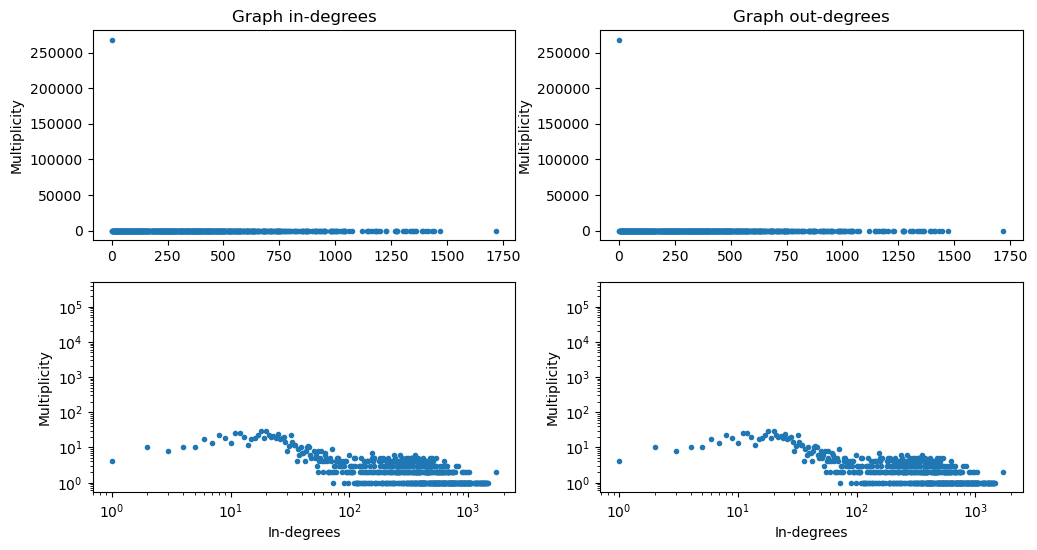

In [3]:
import matplotlib.pyplot as plt
import numpy as np

in_degrees = np.fromiter(dict(graph.in_degree).values(), dtype=int)
counts, bins = np.histogram(in_degrees, bins=np.sort(np.unique(in_degrees)))
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(bins[:-1], counts, ".")
ax[0][0].set_title(label="Graph in-degrees")
ax[0][0].set_ylabel(ylabel="Multiplicity")
ax[1][0].plot(bins[:-1], counts, ".")
ax[1][0].set_ylabel(ylabel="Multiplicity")
ax[1][0].set_xlabel(xlabel="In-degrees")
ax[1][0].set_yscale("log")
ax[1][0].set_xscale("log")

out_degrees = np.fromiter(dict(graph.out_degree).values(), dtype=int)
counts, bins = np.histogram(in_degrees, bins=np.sort(np.unique(in_degrees)))
ax[0][1].plot(bins[:-1], counts, ".")
ax[0][1].set_title(label="Graph out-degrees")
ax[0][1].set_ylabel(ylabel="Multiplicity")
ax[1][1].plot(bins[:-1], counts, ".")
ax[1][1].set_ylabel(ylabel="Multiplicity")
ax[1][1].set_xlabel(xlabel="In-degrees")
ax[1][1].set_yscale("log")
ax[1][1].set_xscale("log")
plt.show()

## Basic statistics

In [4]:
import pandas as pd

def largest_weakly_connected_c(graph):
     # extract largest weakly connected component
    connected_subgraphs = [graph.subgraph(c).copy() for c in nx.weakly_connected_components(graph)]
    max_conn_subgraph_index = np.argmax([len(graph) for graph in connected_subgraphs])
    return connected_subgraphs[max_conn_subgraph_index]

def top_n_by_degree(degree_dict, n):
    stat_view = pd.DataFrame(degree_dict, columns=["Node", "Degree"]).set_index("Node")
    return stat_view.sort_values(["Degree"], ascending=False).head(n)

def basic_stats(graph, top_n):
    G_biggest_comp = largest_weakly_connected_c(graph)

    # Create degree statistics
    degree_stats = top_n_by_degree(G_biggest_comp.degree, top_n)
    in_degree_stats = top_n_by_degree(G_biggest_comp.in_degree, top_n)
    out_degree_stats = top_n_by_degree(G_biggest_comp.out_degree, top_n)

    stats = {"degree": degree_stats, "in_degree": in_degree_stats, "out_degree": out_degree_stats}
    return G_biggest_comp, stats

In [5]:
graph_c, stats  = basic_stats(graph, 5)
print(f"Number of nodes: {graph_c.number_of_nodes()}")
print(f"Number of edges: {graph_c.number_of_edges()}")
print("Top 5 nodes by overall degree")
stats["degree"]

Number of nodes: 270072
Number of edges: 500307
Top 5 nodes by overall degree


,Degree
Node,
Italy,2183
Russia,1821
United States,1628
China,1594
India,1553


In [6]:
print("Top 5 nodes by in degree")
stats["in_degree"]

Top 5 nodes by in degree


,Degree
Node,
Italy,2108
Russia,1720
New York City,1471
History of art,1444
United States,1433


In [7]:
print("Top 5 nodes by out degree")
stats["out_degree"]

Top 5 nodes by out degree


,Degree
Node,
User talk:,980
Wikipedia:Signatures,405
Oxford University Press,279
Cambridge University Press,251
The New York Times,246


## Community analysis

### Entire graph

In [8]:
G_undirected = graph.to_undirected()
G_undirected.remove_nodes_from([node for node in G_undirected.nodes if G_undirected.degree(node) < 1])
louvain_partition = nx.community.louvain_communities(G_undirected)

print( "number of communities found: ", len(louvain_partition))
print("modularity of louvain partitions: ", nx.community.modularity(G_undirected, louvain_partition))

number of communities found:  29
modularity of louvain partitions:  0.6488751342986765


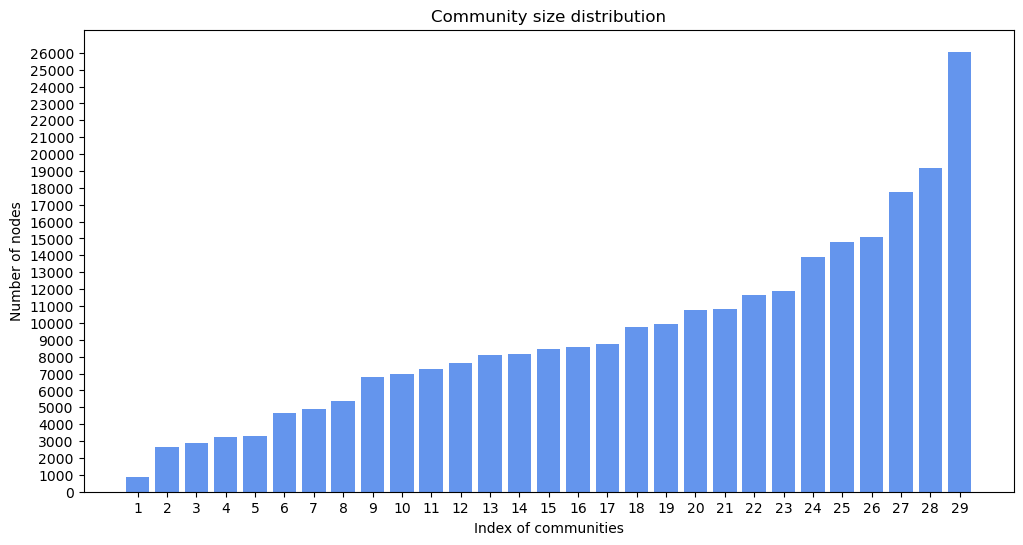

Size of each community printed:  [862, 2621, 2915, 3230, 3276, 4688, 4894, 5364, 6801, 6966, 7263, 7623, 8075, 8167, 8438, 8601, 8735, 9772, 9937, 10739, 10796, 11668, 11875, 13909, 14822, 15063, 17732, 19176, 26064]


In [9]:
sorted_size_communities = sorted([len(comm) for comm in louvain_partition])

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    [x for x in range(1,len(louvain_partition)+1)], 
    sorted_size_communities,
    color="cornflowerblue"
)
ax.set_title(label="Community size distribution")
ax.set_xlabel(xlabel="Index of communities")
ax.set_ylabel(ylabel="Number of nodes")
ax.set_xticks([x for x in range (1,len(louvain_partition)+1)])
ax.set_yticks([i for i in range (0, sorted_size_communities[-1], 1000)])
plt.show()

print("Size of each community printed: ", sorted_size_communities)

In [10]:
def create_grouping(undirected_graph, data_key):
    nodes_with_grouping = dict(undirected_graph.nodes(data=data_key))
    classes = set(nodes_with_grouping.values())
    grouping =  {}
    for type in classes:
        grouping[type] = list(filter(lambda key: nodes_with_grouping[key] == type, nodes_with_grouping))
    return grouping

In [11]:
type_grouping = create_grouping(G_undirected, "page_class")
type_partition_modularity = nx.community.modularity(G_undirected, type_grouping.values())
print("Type partition modularity:", type_partition_modularity)

Type partition modularity: 0.06910397852541075


In [12]:
G_articles = graph.subgraph(type_grouping["article"])
articles_c, stats  = basic_stats(G_articles, 5)
print(f"Number of nodes: {articles_c.number_of_nodes()}")
print(f"Number of edges: {articles_c.number_of_edges()}")
print("Top 5 nodes by overall degree")
stats["degree"]

In [66]:
print("Top 5 nodes by in-degree")
stats["in_degree"]

Top 5 nodes by in-degree


,Degree
Node,
Italy,2107
Russia,1719
New York City,1470
History of art,1443
United States,1432


In [67]:
print("Top 5 nodes by out-degree")
stats["out_degree"]

Top 5 nodes by out-degree


,Degree
Node,
Oxford University Press,274
Cambridge University Press,250
The New York Times,243
Latin,210
World War II,209


In [1]:
louvain_partition = nx.community.louvain_communities(G_articles)

print( "number of communities found: ", len(louvain_partition))
print("modularity of louvain partitions: ", nx.community.modularity(G_articles, louvain_partition))

NameError: name 'nx' is not defined

In [73]:
G_talks = graph.subgraph(type_grouping["talk"])
talks_c, stats  = basic_stats(G_talks, 5)
print(f"Number of nodes: {talks_c.number_of_nodes()}")
print(f"Number of edges: {talks_c.number_of_edges()}")
print("Top 5 nodes by overall degree")
print(stats["degree"])

print("Top 5 nodes by in-degree")
print(stats["in_degree"])

print("Top 5 nodes by out-degree")
print(stats["out_degree"])

Number of nodes: 9894
Number of edges: 13783
Top 5 nodes by overall degree
                              Degree
Node                                
User talk:                       980
Talk:                            159
User talk:InternetArchiveBot     149
User talk:PrimeBOT               126
Talk:Israel                      100
Top 5 nodes by in-degree
                         Degree
Node                           
Talk:Israel                 100
Talk:Cyrillic script         86
Talk:Laser                   72
Talk:Islamic Golden Age      72
Talk:State of matter         63
Top 5 nodes by out-degree
                              Degree
Node                                
User talk:                       980
Talk:                            159
User talk:InternetArchiveBot     149
User talk:PrimeBOT               126
User talk:Community Tech bot      88


In [74]:
G_users = graph.subgraph(type_grouping["user"])
users_c, stats  = basic_stats(G_users, 5)
print(f"Number of nodes: {users_c.number_of_nodes()}")
print(f"Number of edges: {users_c.number_of_edges()}")
print("Top 5 nodes by overall degree")
print(stats["degree"])

print("Top 5 nodes by in-degree")
print(stats["in_degree"])

print("Top 5 nodes by out-degree")
print(stats["out_degree"])

Number of nodes: 1
Number of edges: 0
Top 5 nodes by overall degree
               Degree
Node                 
User:Flfeneru       0
Top 5 nodes by in-degree
               Degree
Node                 
User:Flfeneru       0
Top 5 nodes by out-degree
               Degree
Node                 
User:Flfeneru       0
